In [1]:
import pandas as pd
from tqdm import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [2]:
df = pd.read_csv('../data/results/epa_preds.csv')
df.head()

,gpid,safety_nfl_id,sample_type,x,y,vx,vy,start_x,start_y,start_dir,start_s,predicted_epa
0,2023090700_101,46137,original,20.870000,4.630000,2.600729,-7.501987,53.08,20.04,326.31,2.59,-1.703370
1,2023090700_101,46137,simulated,72.955746,15.432903,6.819203,-1.580656,53.08,20.04,326.31,2.59,-1.956895
2,2023090700_101,46137,simulated,73.159746,16.682307,6.904139,-1.154496,53.08,20.04,326.31,2.59,-1.950902
3,2023090700_101,46137,simulated,73.280823,17.979474,6.963866,-0.710329,53.08,20.04,326.31,2.59,-1.941733
4,2023090700_101,46137,simulated,73.310887,19.321168,6.995585,-0.248563,53.08,20.04,326.31,2.59,-1.913661


In [3]:
gpids = df.gpid.unique()

len(gpids)

213

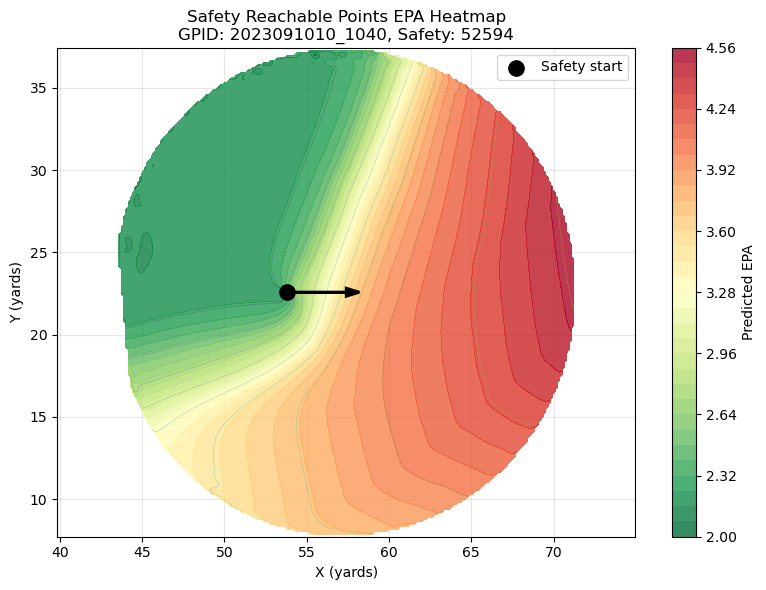

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

def plot_safety_reach_heatmap(df):
    """
    df must contain:
    - x, y, vx, vy for simulated/original points
    - start_x, start_y, start_dir, start_s for the safety origin
    - predicted_epa
    """

    # Extract safety start information (same for all rows in group)
    start_x = df["start_x"].iloc[0]
    start_y = df["start_y"].iloc[0]

    # Convert the direction + speed into a vector for plotting
    # start_dir is in degrees, convert to radians
    dir_rad = np.deg2rad(df["start_dir"].iloc[0])
    speed = df["start_s"].iloc[0]

    vec_dx = np.cos(dir_rad) * speed
    vec_dy = np.sin(dir_rad) * speed

    # Extract simulated points (exclude original if you want)
    sim = df[df["sample_type"] == "simulated"]

    xs = sim["x"].values
    ys = sim["y"].values
    epa = sim["predicted_epa"].values

    # Create figure
    plt.figure(figsize=(8, 6))

    # Create a grid for interpolation
    grid_resolution = 200
    xi = np.linspace(xs.min(), xs.max(), grid_resolution)
    yi = np.linspace(ys.min(), ys.max(), grid_resolution)
    xi_grid, yi_grid = np.meshgrid(xi, yi)

    # Interpolate EPA values onto the grid using cubic interpolation
    zi_grid = griddata((xs, ys), epa, (xi_grid, yi_grid), method='cubic', fill_value=np.nan)

    # Create a mask for points outside the convex hull (to maintain the circular shape)
    from scipy.spatial import ConvexHull
    points = np.column_stack((xs, ys))
    hull = ConvexHull(points)
    
    # Create path from hull vertices to mask outside points
    from matplotlib.path import Path
    hull_path = Path(points[hull.vertices])
    grid_points = np.column_stack((xi_grid.ravel(), yi_grid.ravel()))
    mask = hull_path.contains_points(grid_points).reshape(xi_grid.shape)
    zi_grid[~mask] = np.nan

    # Plot the gradient heatmap
    im = plt.contourf(xi_grid, yi_grid, zi_grid, levels=40, cmap="RdYlGn_r", alpha=0.8, zorder=3)
    
    # Add contour lines for better visualization
    plt.contour(xi_grid, yi_grid, zi_grid, levels=10, alpha=0.3, linewidths=0.5, zorder=4)

    # --- Safety starting point & vector ---
    plt.scatter(start_x, start_y, color="black", s=100, label="Safety start", 
                zorder=6, edgecolors='black', linewidths=2)
    plt.arrow(start_x, start_y, vec_dx, vec_dy,
              head_width=0.5, head_length=0.8,
              fc="black", ec="black", linewidth=2, zorder=5)

    # Colorbar
    cbar = plt.colorbar(im)
    cbar.set_label("Predicted EPA")

    plt.xlabel("X (yards)")
    plt.ylabel("Y (yards)")
    plt.title(f"Safety Reachable Points EPA Heatmap\nGPID: {df['gpid'].iloc[0]}, Safety: {df['safety_nfl_id'].iloc[0]}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Example usage:
example_gpid = df["gpid"].unique()[140]
example_df = df[df["gpid"] == example_gpid]
plot_safety_reach_heatmap(example_df)